In [1]:
import os

from lxml import etree
import base64
from bs4 import BeautifulSoup
import re
from nltk.tokenize import RegexpTokenizer
from urllib.parse import urljoin
import pymorphy2
import string
from collections import Counter

import numpy as np

from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

BYWEB_PATH = os.path.join('data', 'byweb_for_course')
STOPWORDS_EN = os.path.join('data', 'stopwords', 'english')
STOPWORDS_RU = os.path.join('data', 'stopwords', 'russian')

In [2]:
class Document:
    def __init__(self, raw):
        self.raw = raw

In [3]:
def pipeline(docs, foo_list):
    for foo in foo_list:
        def generator(docs, foo):
            for doc in docs:
                yield foo(doc)
        docs = generator(docs, foo)
    return docs

def generate_raw_docs(db_path):
    for file_name in tqdm(os.listdir(db_path)):
        file_path = os.path.join(db_path, file_name)
        root = etree.parse(file_path).getroot()
        for raw in root.getchildren():
            yield Document(raw)

In [4]:
def decoded_doc(doc):
    doc.html, doc.url, doc.doc_id = \
        list(map(lambda x: x.text, doc.raw))
    doc.url = base64.urlsafe_b64decode(doc.url).decode('cp1251')
    doc.html = base64.b64decode(doc.html).decode('cp1251')
    return doc

In [5]:
def build_text(doc):
    soup = BeautifulSoup(doc.html, 'lxml')
    for script in soup(['script', 'style']):
        script.decompose()
    doc.text = soup.get_text()
    doc.text = re.sub('(<!--.*?-->)', '', doc.text, flags=re.DOTALL)
    return doc

In [6]:
def get_tokenize_foo():
    tokenizer = RegexpTokenizer(r'\w+')
    def tokenize(doc):
        doc.tokens = tokenizer.tokenize(doc.text)
        return doc
    return tokenize

In [7]:
def get_lemmatization_foo():
    analyzer = pymorphy2.MorphAnalyzer()
    def lemmatization(doc):
        doc.lemmed_tokens = list(map(lambda x: x.lower(), doc.tokens))
        doc.lemmed_tokens = list(map(lambda x: analyzer.parse(x)[0].normal_form, doc.lemmed_tokens))
        return doc
    return lemmatization

In [8]:
def find_links(doc):
    soup = BeautifulSoup(doc.html)
    for script in soup(["script", "style"]):
        script.decompose()
    
    doc.links = set()
    for link in soup.findAll('a'):
        link_url = link.get('href')
        if not link_url or link_url[0] == '#':
            continue
        try:
            link_url = urljoin(url, link_url)
            doc.links.add(link_url)
        except Exception:
            pass
        
    return doc

In [ ]:
docs = pipeline(generate_raw_docs(BYWEB_PATH),
                [decoded_doc, build_text, get_tokenize_foo(), get_lemmatization_foo(), find_links])

doc_count = 0
content_byte_lens = []
content_word_lens = []
text_html_ratios = []
collection_dict = Counter()
count_for_idf = Counter()

for doc in docs:
    doc_count += 1
    content_byte_lens.append(len(doc.text))
    content_word_lens.append(len(doc.tokens))
    text_html_ratios.append(len(doc.text) / len(doc.html))
    
    collection_dict.update(doc.lemmed_tokens)
    
    count_for_idf.update(list(set(doc.lemmed_tokens)))

In [20]:
print('Count of docs: {}'.format(doc_count))

Count of docs: 200000


Mean doc length in bytes: 6633.092785


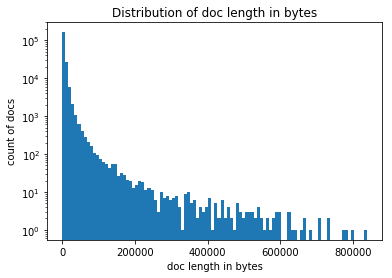

In [31]:
print('Mean doc length in bytes: {}'.format(np.array(content_byte_lens).mean()))

plt.hist(content_byte_lens, bins=100)
plt.yscale('log')
plt.xlabel('doc length in bytes')
plt.ylabel('count of docs')
plt.title('Distribution of doc length in bytes')
plt.show()

Mean doc length in words: 857.065965


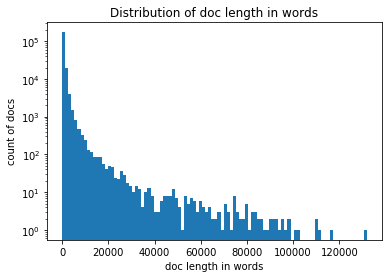

In [22]:
print('Mean doc length in words: {}'.format(np.array(content_word_lens).mean()))

plt.hist(content_word_lens, bins=100)
plt.yscale('log')
plt.xlabel('doc length in words')
plt.ylabel('count of docs')
plt.title('Distribution of doc length in words')
plt.show()

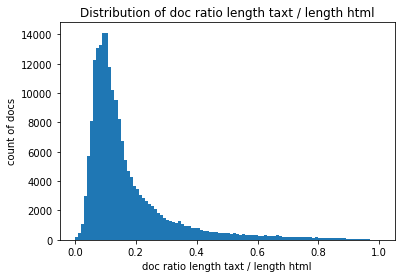

In [23]:
plt.hist(text_html_ratios, bins=100)
plt.xlabel('doc ratio length taxt / length html')
plt.ylabel('count of docs')
plt.title('Distribution of doc ratio length taxt / length html')
plt.show()

In [24]:
stopwords = set([line.rstrip('\n') for file_path in [STOPWORDS_EN, STOPWORDS_RU]
                                   for line in open(file_path)])

collection_word_cnt = sum(collection_dict[w] for w in collection_dict)
collection_stopword_cnt = sum(w in stopwords for w in collection_dict)

print('{} words of {} words in all collection are stop-words'.format(
    collection_stopword_cnt, collection_word_cnt))
print('That is {:.4}%'.format(100 * collection_stopword_cnt / collection_word_cnt))

277 words of 171413193 words in all collection are stop-words
That is 0.0001616%


In [25]:
alphabet = set(list(string.ascii_lowercase))
def is_latin(word):
    return len(list(filter(lambda c: c not in alphabet, word))) == 0

collection_latinword_cnt = sum(int(is_latin(w)) for w in collection_dict)

print('{} words of {} words in all collection are latin-words'.format(
    collection_latinword_cnt, collection_word_cnt))
print('That is {:.4}%'.format(100 * collection_latinword_cnt / collection_word_cnt))

506497 words of 171413193 words in all collection are latin-words
That is 0.2955%


In [26]:
collection_word_sum_len = sum(len(w) * collection_dict[w] for w in collection_dict)
dict_word_sum_len = sum(len(w) for w in collection_dict)

print('Mean length of word in all collection is: {}'.format(collection_word_sum_len / collection_word_cnt))
print('Mean length of word in dictionary is: {}'.format(dict_word_sum_len / len(collection_dict)))

Mean length of word in all collection is: 5.507521600160613
Mean length of word in dictionary is: 10.049101036348178


In [27]:
print('Most common words in collection are:')
for word, cnt in collection_dict.most_common(20):
    print('Word "{}" occurs {} times'.format(word, cnt))

Most common words in collection are:
Word "и" occurs 3550904 times
Word "в" occurs 3520978 times
Word "на" occurs 1827282 times
Word "с" occurs 1536126 times
Word "не" occurs 1226303 times
Word "http" occurs 1088145 times
Word "url" occurs 954288 times
Word "1" occurs 948838 times
Word "по" occurs 902937 times
Word "для" occurs 884575 times
Word "год" occurs 880251 times
Word "2007" occurs 772256 times
Word "что" occurs 745608 times
Word "2" occurs 745423 times
Word "весь" occurs 693437 times
Word "а" occurs 683243 times
Word "я" occurs 634318 times
Word "быть" occurs 626557 times
Word "о" occurs 614339 times
Word "a" occurs 610234 times


In [28]:
idf = {word: np.log(doc_count / count_for_idf[word]) for word in count_for_idf}

print('Words with largest idf are:')
for word in sorted(idf, key=idf.get)[:20]:
    print('Word "{}" has idf={:.4}'.format(word, idf[word]))

Words with largest idf are:
Word "в" has idf=0.1278
Word "и" has idf=0.1613
Word "на" has idf=0.2075
Word "с" has idf=0.2877
Word "by" has idf=0.3239
Word "по" has idf=0.3569
Word "для" has idf=0.358
Word "о" has idf=0.3659
Word "весь" has idf=0.391
Word "1" has idf=0.4073
Word "2" has idf=0.4587
Word "год" has idf=0.5258
Word "не" has idf=0.572
Word "3" has idf=0.5738
Word "сайт" has idf=0.5789
Word "2007" has idf=0.5974
Word "главный" has idf=0.6515
Word "к" has idf=0.6624
Word "от" has idf=0.672
Word "5" has idf=0.6782


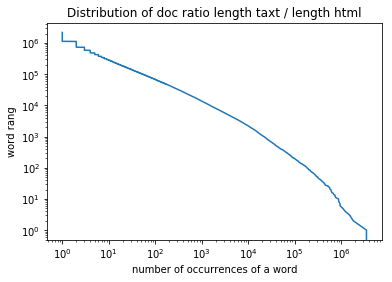

In [29]:
xs = [cnt for _, cnt in collection_dict.most_common()]
ys = list(range(len(collection_dict)))

plt.plot(xs, ys)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('number of occurrences of a word')
plt.ylabel('word rang')
plt.title('Distribution of doc ratio length taxt / length html')
plt.show()